In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np # math
import matplotlib.pyplot as plt # graphs and plots
import pandas as pd
from tqdm import tqdm
import datetime
import matplotlib.dates as mdates
from src.utils.profiles_from_schedule_new import SimParam # class for show-up generator
from src.simfunc.KIX_T1d_CUSBD_new import Pax, Simulation , minutes_to_hms# classes for simulation
import seaborn as sns
from copy import deepcopy
%matplotlib inline
%config InlineBackend.figure_format='retina'



<AxesSubplot:>

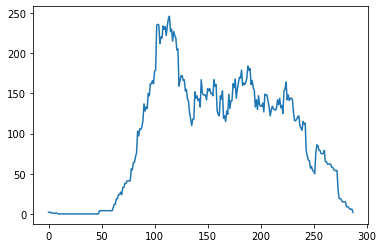

In [3]:
simparam = SimParam()
path_to_6k_sched = (
    r"/home/antoine/projects/"
    "KAPpaxsim/KAPpaxsim/data/"
    "processed/Schedule (30th terminal peak, 6000 pax)_PROCESSED.xlsx"
)
simparam.schedule_from_path(path_to_6k_sched)
simparam.schedule_cleanup()
simparam.schedule_filter()
simparam.show_up_from_file()
simparam.assign_flight_show_up_category_default()
# simparam.plot_show_up_categories_profiles()
# simparam.schedule['PAX_SUM FC'] = 10
simparam.assign_show_up()
# simparam.plot_df_Pax()
simparam.assign_check_in()
simparam.df_Counters["total"].plot()


<AxesSubplot:>

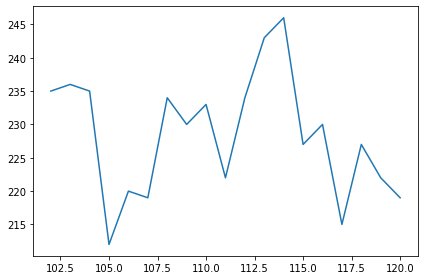

In [15]:
simparam.df_Counters.loc[102:120,"total"].plot()


In [5]:
simparam.df_Counters.loc[110:160, :].sum(axis=0).sort_values(ascending=False).head(
    n=10
).index


Index(['total', 'NEW', 'CAL', 'KAL', 'EVA', 'CSN', 'CES', 'ABL', 'APJ', 'CCA'], dtype='object')

<AxesSubplot:>

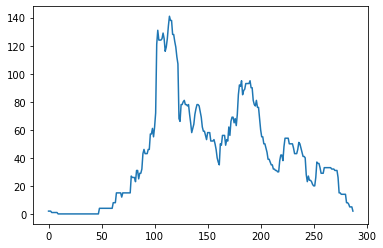

In [6]:
simparam.df_Counters.drop(
    ["NEW", "KAL", "CPA", "ANA", "CAL", "AAR", "JNA", "total"], axis=1
).sum(axis=1).plot()


<AxesSubplot:>

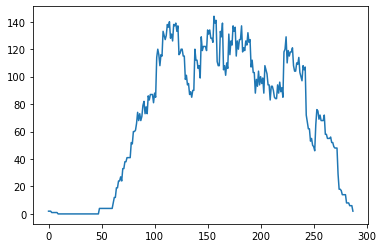

In [7]:
simparam.df_Counters.drop(
    [
        "total",
        "ANA",
        "KAL",
        "CPA",
        "SIA",
        "JNA",
        "AAR",
        "HVN",
        "JJA",
        "CES",
        "CAL",
        "EVA",
        "CSN",
        "THA",
    ],
    axis=1,
).sum(axis=1).plot()


In [8]:
# change show-up

# simparam.df_show_up_profiles['loc'] = 90
# simparam.df_show_up_profiles['scale'] = 30
# simparam.define_norm_show_up(simparam.df_show_up_profiles)
# simparam.plot_show_up_categories_profiles()
# simparam.assign_show_up()


In [9]:
simparam.dct_resource = {
    "kiosk": 92,
    "security": 200,
    "CUSBD": 32,
}

simparam.dct_processes = {
    "kiosk": 70,
    "security": 1,
    "CUSBD": 45,
    "checkin": 70,
}

simparam.dct_process_sequence = {
    "tradi": [
        ["kiosk", "wait_opening", "checkin", "security"],
        {"hour_to_std": 2.5},
    ],
    "CUSBD": [
        ["kiosk", "wait_opening", "CUSBD", "security"],
        {"hour_to_std": 2.5},
    ],
}

mask_CUSBD_case1 = simparam.df_Pax["Airline"].isin(
    ["NEW", "KAL", "CPA", "ANA", "CAL", "AAR", "JNA"]
)

mask_CUSBD_case2 = simparam.df_Pax["Airline"].isin(
    [
        "ANA",
        "KAL",
        "CPA",
        "SIA",
        "JNA",
        "AAR",
        "HVN",
        "JJA",
        "CES",
        "CAL",
        "EVA",
        "CSN",
        "THA",
    ]
)

dct_mask = {
    "case1": mask_CUSBD_case1,
    "case2": mask_CUSBD_case2,
}

dct_simparam = {
    "case1": simparam,
    "case2": deepcopy(simparam),
}

for case in dct_mask:
    mask_tradi = dct_mask[case] == False
    dct_simparam[case].df_Pax.loc[dct_mask[case], "pax_type"] = "CUSBD"
    dct_simparam[case].df_Pax.loc[mask_tradi, "pax_type"] = "tradi"

# Need to make a pretty control for :
#     - plotting process list_all

# Need to add:
#     - graph for wait_opening

# Need to check that check-in capacity is working properly
# Test a saturation with dummy figures

case1


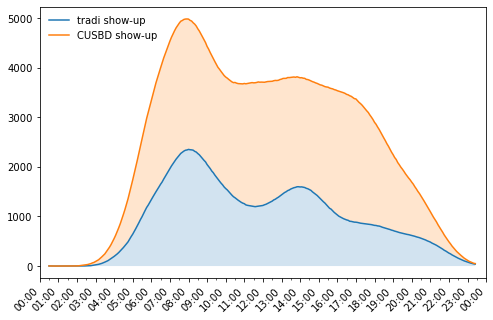

case2


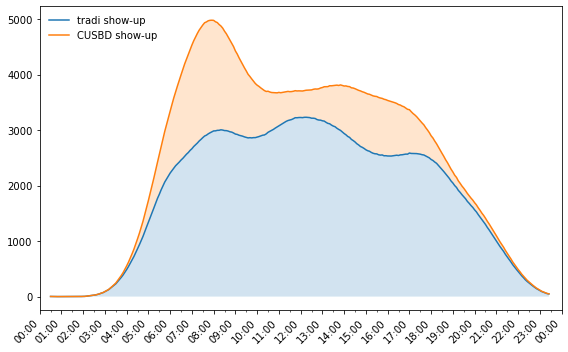

In [10]:
for key,simparam in dct_simparam.items():
    print(key)
    simparam.plot_df_Pax(by_pax_type=True)


In [11]:
dct_simulation = {}

for key, simparam in dct_simparam.items():
    dct_simulation[key] = Simulation(simparam)
    dct_simulation[key].generate_checkin()
    dct_simulation[key].generate_pax()
    dct_simulation[key].run(end_time=1440)


Simulation running...: 100%|██████████| 1439/1439 [43:51<00:00,  1.83s/it]  


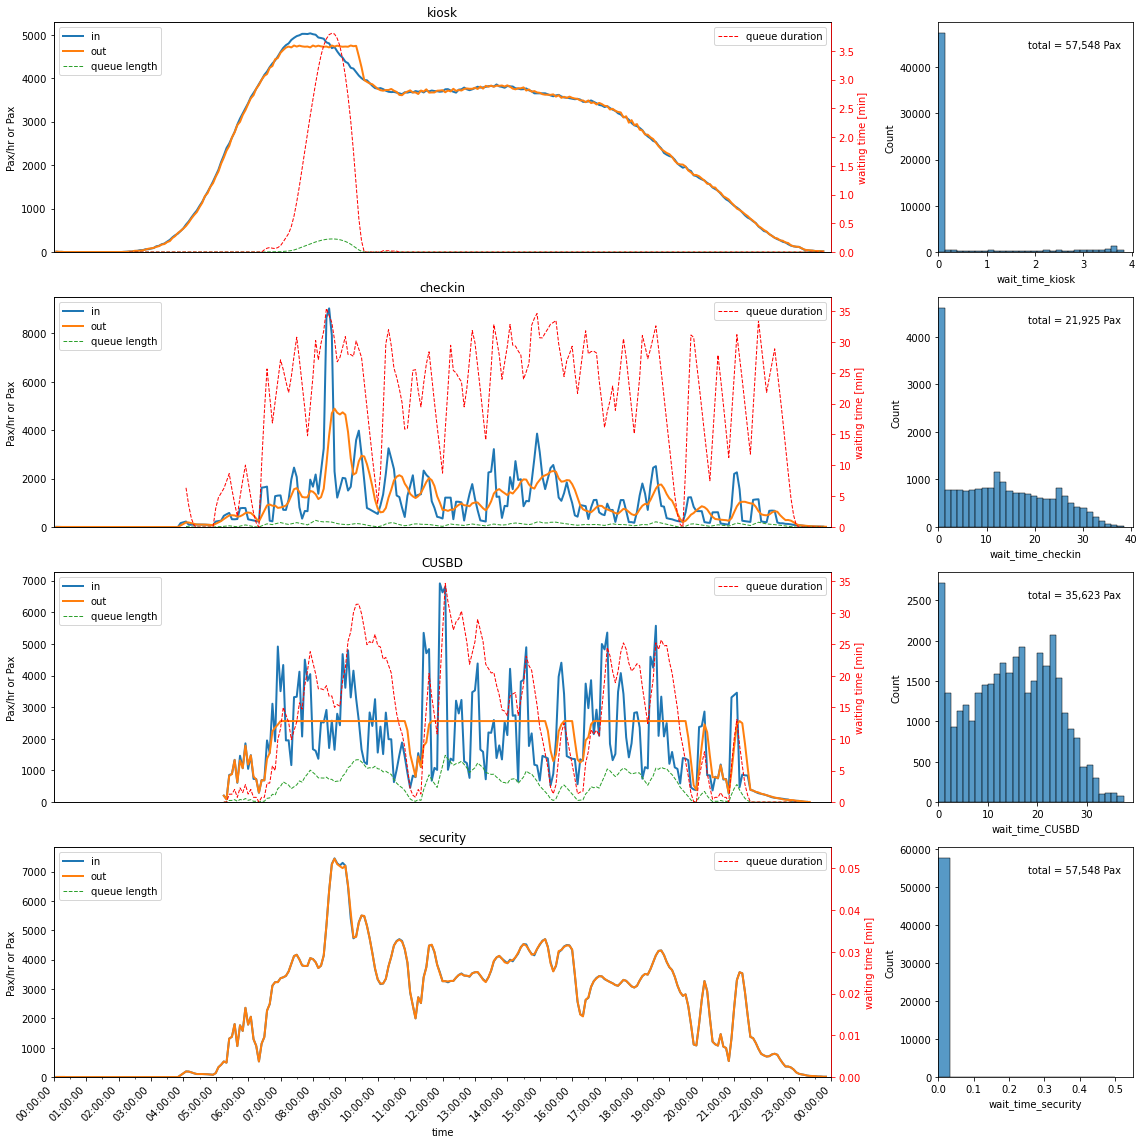

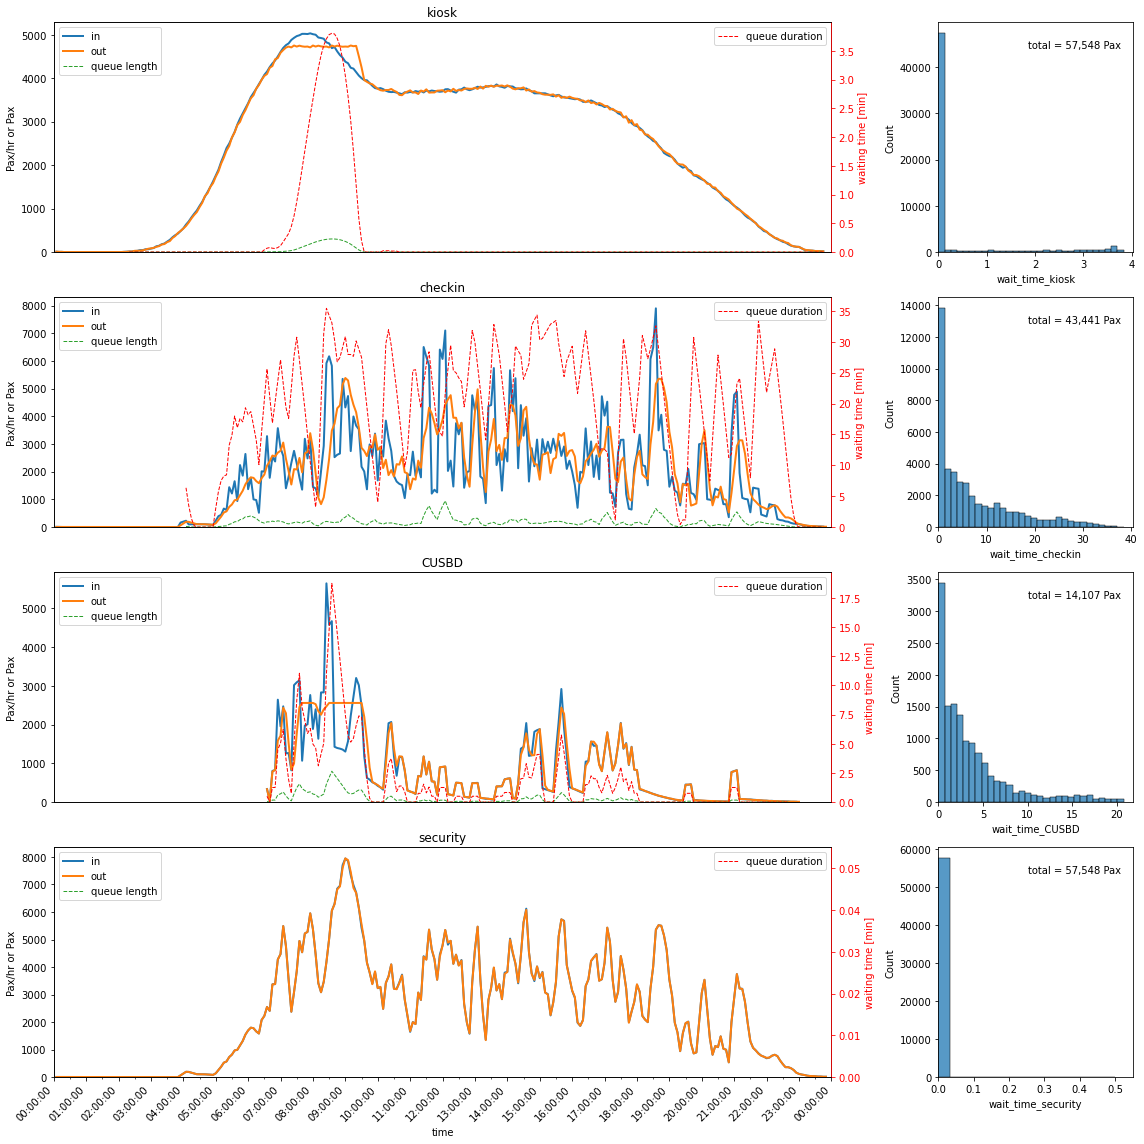

In [12]:
for key, simparam in dct_simparam.items():
    dct_simulation[key].format_df_result().plot_result()


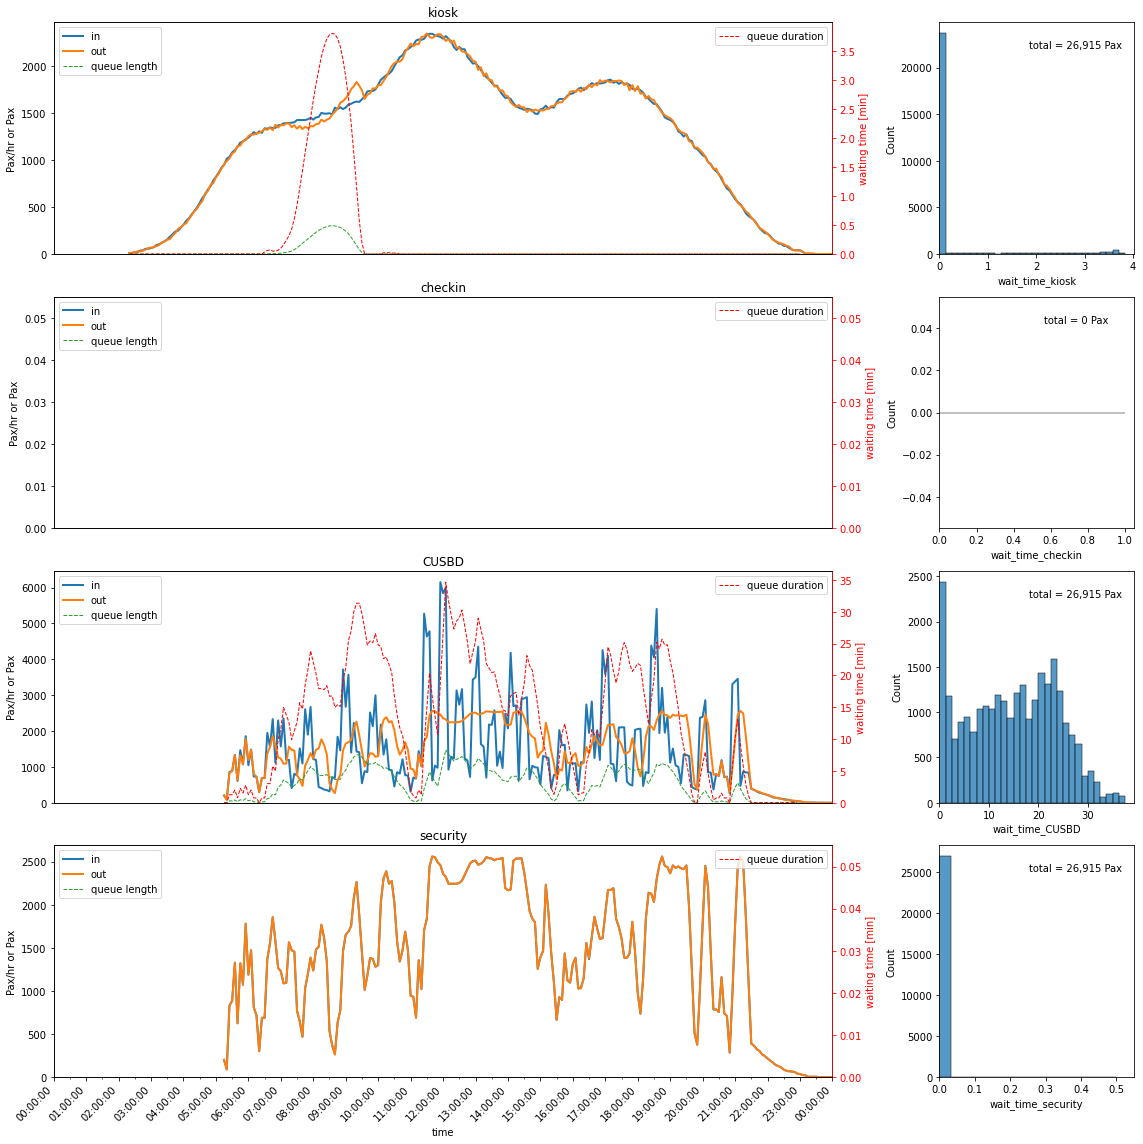

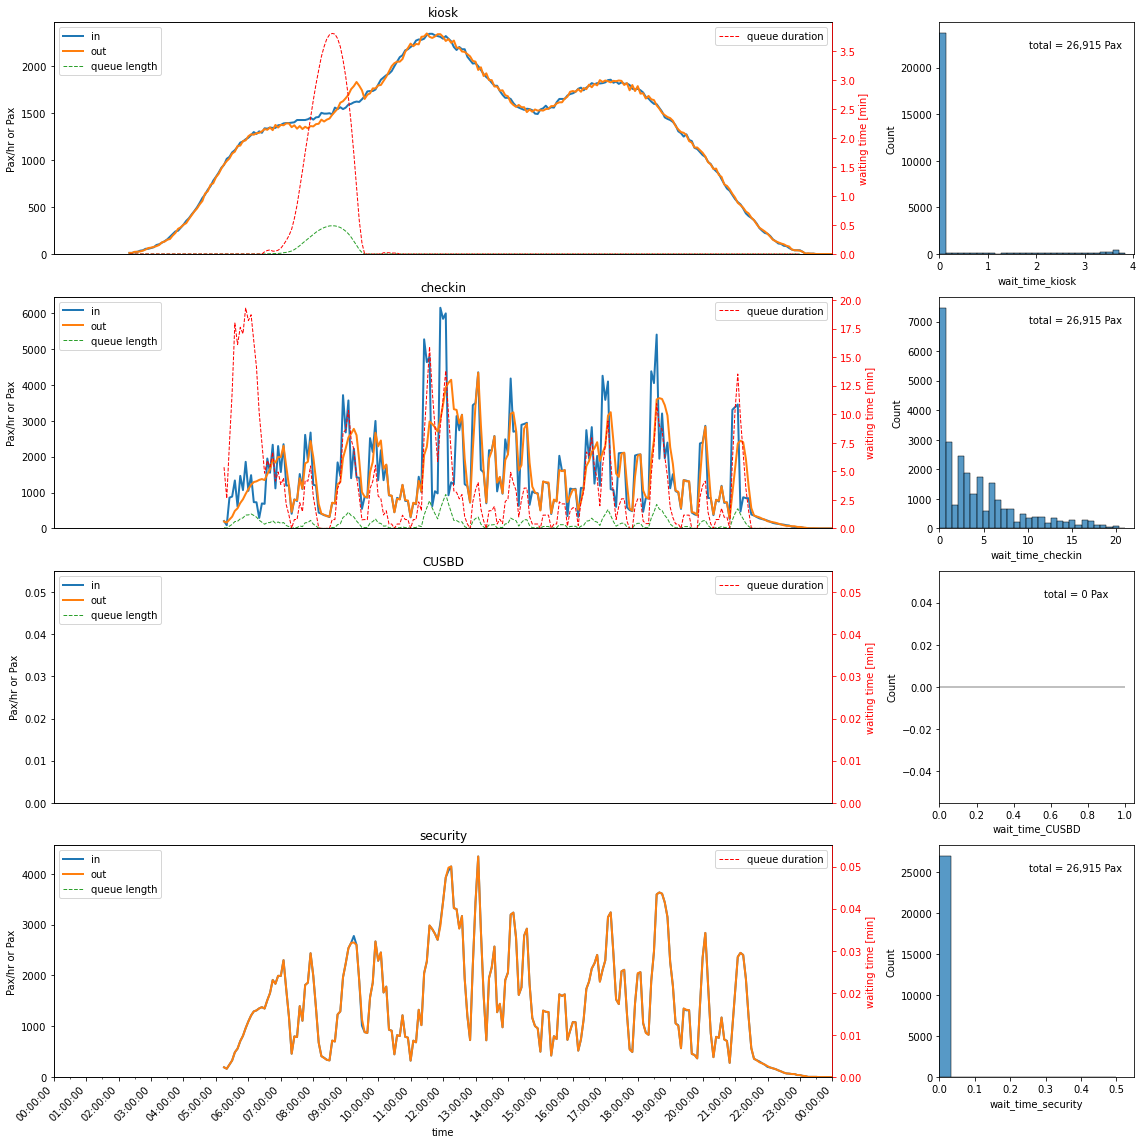

In [13]:
for key, simparam in dct_simparam.items():
    dct_simulation[key].format_df_result(filter_airline=["NEW"]).plot_result()


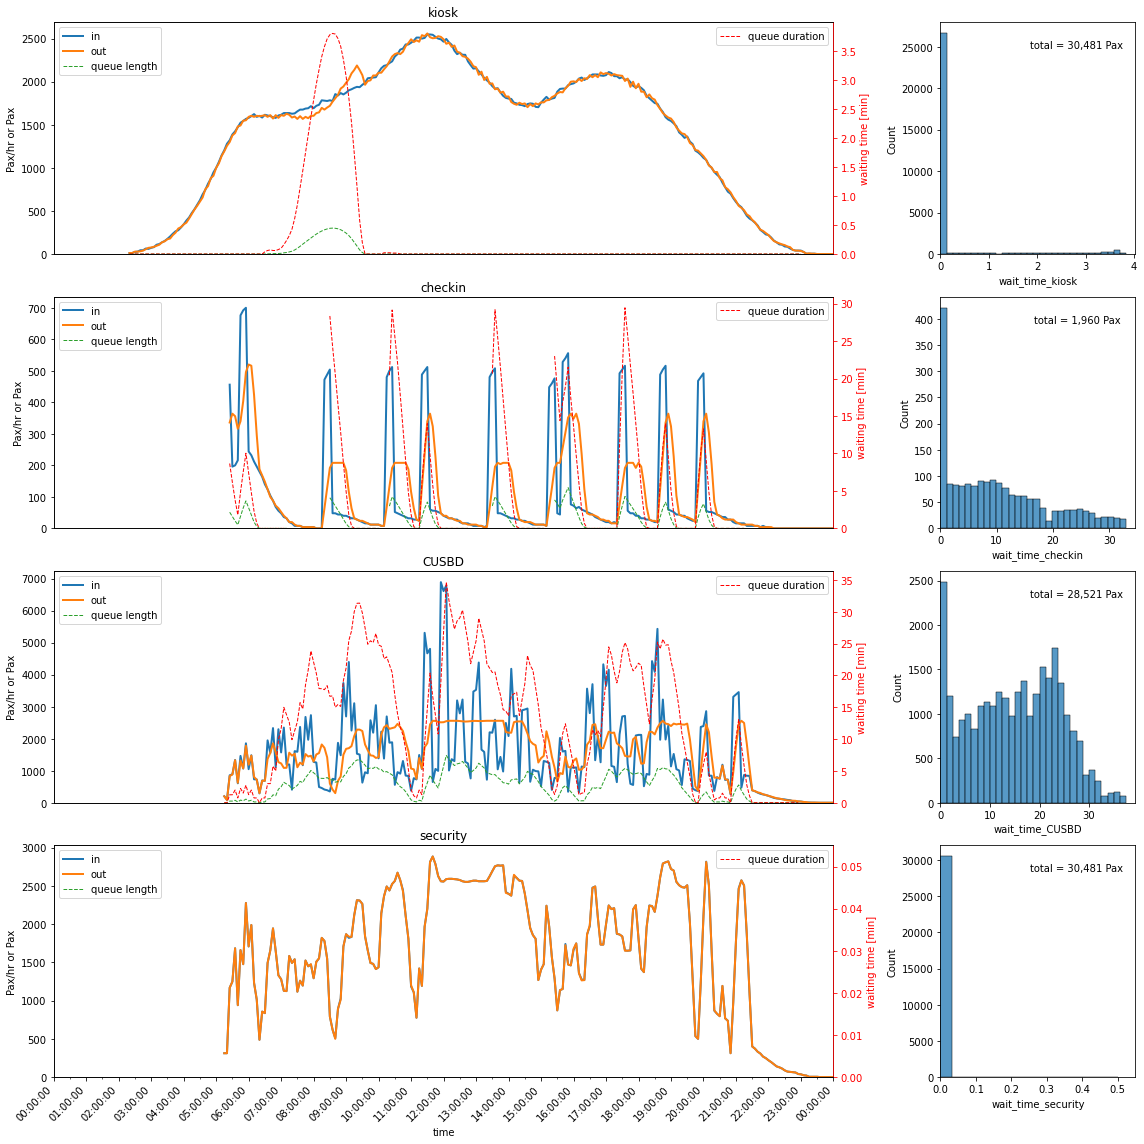

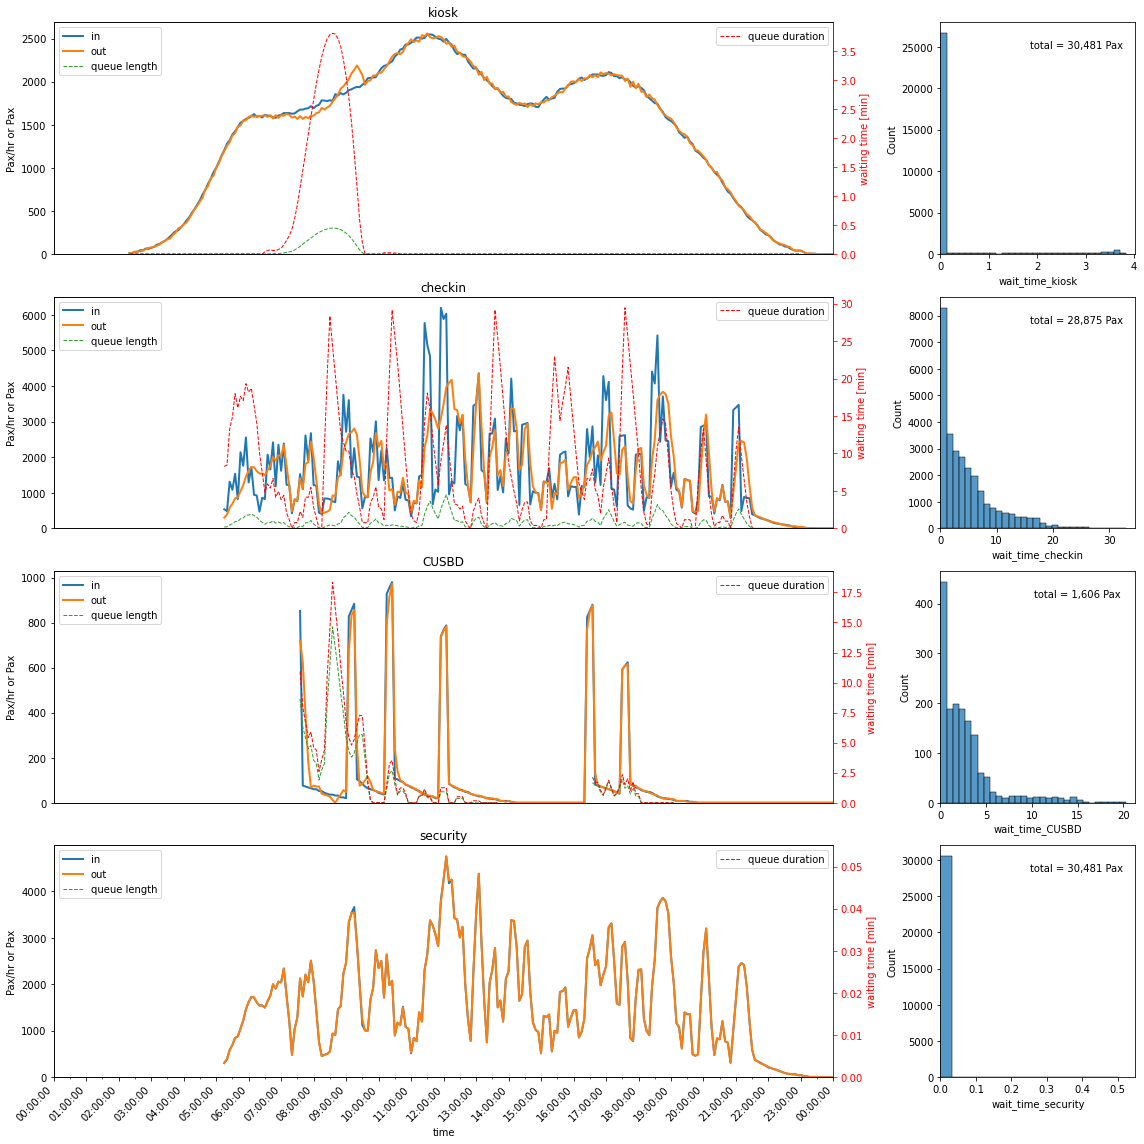

In [14]:
for key, simparam in dct_simparam.items():
    dct_simulation[key].format_df_result(
        filter_airline=["NEW", "CAL", "APJ"]
    ).plot_result()
